In [4]:
%matplotlib inline

# Examples of differences between composite Shapley and one-vs-rest Shapley

Composite Shapley

- Unique ordering of feature importance based on the norm of the vectors in the ILR space
- The feature contribution path contains all the information.

Shapley

- One ordering of feature importance per one-vs-rest class Shapley
- Instances with different feature importance paths in the ILR space may show the same Shapley values in the one-vs-rest form

In [32]:
import matplotlib.pyplot as plt
import numpy as np

cm = plt.cm.tab10
colors = cm.colors
cm

plt.rcParams['axes.grid'] = True

# Definition of a coordinate system in ILR space

Isometric Log-ratio space

In [81]:
def rotate(vector, angle):
    radians = np.radians(angle)
    return np.inner(np.array([[np.cos(radians), -np.sin(radians)],
                              [np.sin(radians), np.cos(radians)]]),
                    vector.T)

def plot_coordinate_system(ax):

    class_coordinates = np.array([np.array([0, 1]),
                            rotate(np.array([0, 1]), -120),
                            rotate(np.array([0, 1]),  120)])
    

    for i, coord in enumerate(class_coordinates):
        ax.arrow(0, 0, coord[0], coord[1], shape='full', head_width=0.1, color=colors[i])
        ax.text(coord[0]/2, coord[1]/2, f"$C_{i}$")
    
    decision_boundaries = np.array([rotate(np.array([0, 3]), 60),
                           rotate(np.array([0, 3]), 60+120),
                           rotate(np.array([0, 3]), 60+240)])
    
    for i, coord in enumerate(decision_boundaries):
        ax.arrow(0, 0, coord[0], coord[1], linestyle='--')
    
    ax.set_box_aspect(1)

Example of the coordinate system

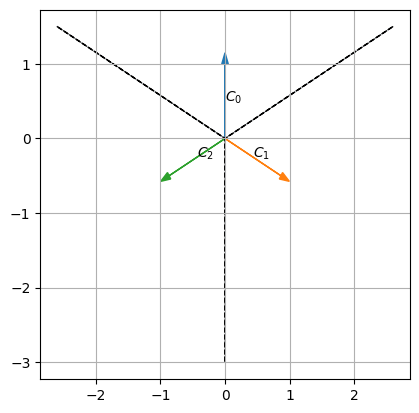

In [82]:
fig = plt.figure()
ax = plt.subplot()
plot_coordinate_system(ax=ax)

## Definition of instances and feature contributions

In [83]:
base = np.array([0, 0])
instance1 = np.array([[0.5, 0.5], [0, 2]])

instance_list = [instance1,
                 instance1*np.array([-1, 1])]

print(instance_list)

[array([[0.5, 0.5],
       [0. , 2. ]]), array([[-0.5,  0.5],
       [-0. ,  2. ]])]


## Plot feature contributions of each instance

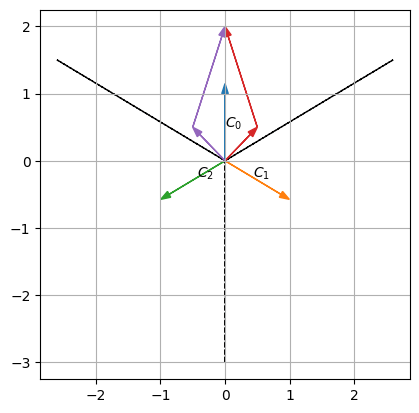

In [84]:
def plot_instances(instance_list, ax):
    instance_colors = colors[3:]
    
    for i, instance in enumerate(instance_list):
        last = base
        color = instance_colors[i]
        for i in range(len(instance)):
            d_next = instance[i] - last
            ax.arrow(x=last[0], y=last[1], dx=d_next[0], dy=d_next[1],
                     shape='full', head_width=0.1, length_includes_head=True,
                     color=color)
            last = d_next

fig = plt.figure()
ax = plt.subplot()
plot_coordinate_system(ax=ax)
plot_instances(instance_list, ax=ax)

## Feature contributions in ILR and probability space

**TODO**: The current basis is not correct.

In [80]:
from composition_stats import ilr, sbp_basis
from shapleycomposition import ilr_inv

sbpmatrix=np.array([[1,-1,0],
                    [1,1,-1]])
basis = sbp_basis(sbpmatrix)

base_prob = ilr_inv(base, basis=basis)
print(f"Base in ILR space = {base}")
print(f"Base probabilities = {base_prob}")
print()

for i, instance in enumerate(instance_list):
    print(f"Instance {i}")
    for j, feature in enumerate(instance):
        print(f"\tFeature {j} in ILR space = {feature}")
        ilr_feat = ilr_inv(feature, basis=basis)
        print(f"\t\tin probability space = {ilr_feat}")
    print()

Base in ILR space = [0 0]
Base probabilities = [0.33333333 0.33333333 0.33333333]

Instance 0
	Feature 0 in ILR space = [0.5 0.5]
		in probability space = [0.53370356 0.26315252 0.20314393]
	Feature 1 in ILR space = [0. 2.]
		in probability space = [0.47930881 0.47930881 0.04138239]

Instance 1
	Feature 0 in ILR space = [-0.5  0.5]
		in probability space = [0.26315252 0.53370356 0.20314393]
	Feature 1 in ILR space = [-0.  2.]
		in probability space = [0.47930881 0.47930881 0.04138239]



## One-vs-rest SHAP contributions

**TODO:** Need to add the feature contributions projected into each class